# PIK3CA Methods - Analyzing the cis effects of PIK3CA mutation on p110

PIK3CA is a gene that encodes for the protein kinase p110α, which is involved in a phosphorylation signaling cascade that plays a key role in cell survival and proliferation. 

We investigated the effects of PIK3CA mutation on its own proteomic and phosphoproteomic abundances. 

We compared the data from those with hotspot mutations in PIK3CA with other cancer patients with no PIK3CA mutation (cancer wildtype). We also compared all patients with any PIK3CA mutation with this cancer wildtype group.

## Standard Imports

### Python packages used for analysis and plotting

In [44]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import re 

<b> Import CPTAC data </b>

In [45]:
import CPTAC.Endometrial as CPTAC

# 1. Set up initial dataframes and variables 

In [46]:
gene = 'PIK3CA'
somatic = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

#A list of mutations present in the hotspot according to our Hotspot3D output
hotspot_mutations = ['p.E545A', 'p.E545K', 'p.E545V', 'p.Q546P', 'p.Q546R', 'p.E542K']
mutated_hotspot = somatic.loc[(somatic['Location'].isin(hotspot_mutations)) & (somatic['Gene'] == gene)]
hotspot_patients = mutated_hotspot['Clinical_Patient_Key']
print(hotspot_patients)

#The pvalue cutoff used to find significance
pcutoff = 0.05


160      S001
1147     S003
1357     S009
4630     S021
16486    S023
19061    S024
21259    S032
21516    S033
22497    S038
37421    S061
38155    S063
39522    S066
43391    S067
43490    S068
46662    S084
47360    S088
47857    S090
49362    S097
49475    S098
Name: Clinical_Patient_Key, dtype: object


# 2. Find number of patients with PIK3CA mutations in/outside the hotspot

In [64]:
print('{}''{}'.format('Patients with mutations inside hotspot: ', len(hotspot_patients)))
p110_mutated = somatic.loc[somatic['Gene'] == 'PIK3CA']
#note: the gene PIK3CA encodes for the protein p110α, hence the variable 'p110_mutated'

# This naturally includes a value that is 'NA' so we subtract 1
# Some people have more than one mutation so we need to grab the unique values
num_mutated = len(set(p110_mutated['Clinical_Patient_Key'])) - 1
print('{}' '{}'.format('Total number of patients with PIK3CA mutations: ', num_mutated))

print(p110_mutated)

Patients with mutations inside hotspot: 19
Total number of patients with PIK3CA mutations: 46
      Clinical_Patient_Key Patient_Id    Gene           Mutation  \
160                   S001  C3L-00006  PIK3CA  Missense_Mutation   
1147                  S003  C3L-00032  PIK3CA  Missense_Mutation   
1357                  S009  C3L-00139  PIK3CA  Missense_Mutation   
1505                  S010  C3L-00143  PIK3CA  Missense_Mutation   
2191                  S012  C3L-00156  PIK3CA  Missense_Mutation   
2192                  S012  C3L-00156  PIK3CA  Missense_Mutation   
3315                  S014  C3L-00161  PIK3CA  Missense_Mutation   
3316                  S014  C3L-00161  PIK3CA  Missense_Mutation   
4521                  S018  C3L-00362  PIK3CA  Missense_Mutation   
4629                  S021  C3L-00563  PIK3CA  Missense_Mutation   
4630                  S021  C3L-00563  PIK3CA  Missense_Mutation   
7089                  S022  C3L-00586  PIK3CA  Missense_Mutation   
7090                  

## 2a. Show the different mutation types

Missense_Mutation    58
In_Frame_Del          3
Frame_Shift_Ins       1
Name: Mutation, dtype: int64


/Users/emilyhosk/anaconda3/envs/research/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


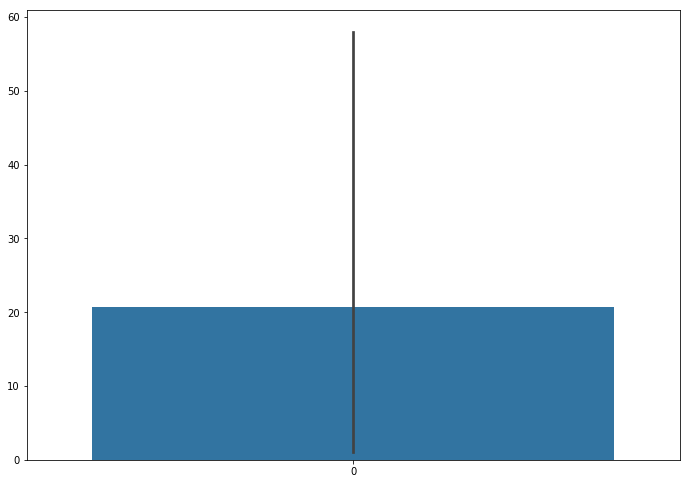

In [69]:
mut_counts = p110_mutated['Mutation'].value_counts()
print(mut_counts)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.barplot(data = mut_counts)
plt.show()


# 3. PIK3CA cis effects

# 3a. Proteomics analysis

In [60]:
protein = 'PIK3CA'
# 1. Merge the mutation status of PIK3CA and the protemics data of PIK3CA
p110_mutations_protein = CPTAC.compare_mutations(proteomics, protein)
#note - CPTAC will return a dataframe of the mutation status and proteomics of the same gene 
#   if only two parameters are provided: the dataframe and the mutation/protein being analyzed

# 2. Set up a new column for mutations that are within the hotspot
p110_mutations_protein['Within_Hotspot'] = 'Outside Hotspot'
p110_mutations_protein.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p110_mutations_protein.loc[p110_mutations_protein['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'

# 3. Select for tumor samples only 
p110_mutations_protein = p110_mutations_protein.loc[p110_mutations_protein['Sample_Status'] == 'Tumor'].dropna(axis=0)

# 4. Make three new dataframes, one for people with a hotspot mutation, one for those with mutations outside the hotspot, and  one for all the wildtype cancer patients
hotspot_mut = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Within Hotspot'] 
non_hotspot_mut = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Outside Hotspot']
wt = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] == 'Wildtype_Tumor']


# 5. ttest for proteomics of PIK3CA between wildtype cancer and hotspot mutation
tstat, pvalue = scipy.stats.ttest_ind(hotspot_mut[protein], wt[protein])
print('{}' '{}' '{}' '{}'.format(protein, ' proteomics hotspot mutations vs wildtype: ', pvalue, '\n'))
#print(protein + ' proteomics hotspot mutations vs wildtype: ' + str(pvalue), '\n')

#Perform a ttest for non-hotspot mutations vs wildtype 
tstat, pvalue = scipy.stats.ttest_ind(non_hotspot_mut[protein], wt[protein])
#print('Non-hotspot mutations vs wildtype: ' + str(pvalue), '\n')
print('{}' '{}' '{}'.format('Non-hotspot mutations vs wildtype: ', pvalue, '\n'))

# 6. Repeat for all mutations vs wildtype cancer
all_mutated = p110_mutations_protein.loc[p110_mutations_protein['Within_Hotspot'] != 'Wildtype']
tstat, pvalue = scipy.stats.ttest_ind(all_mutated[protein], wt[protein])
print('{}' '{}' '{}'.format(protein, " proteomics all mutation vs wildtype: " , pvalue))

PIK3CA proteomics hotspot mutations vs wildtype: 0.01233605106007355

Non-hotspot mutations vs wildtype: 0.21730633159516427

PIK3CA proteomics all mutation vs wildtype: 0.21599910302109096


# 3b. Plot the data 

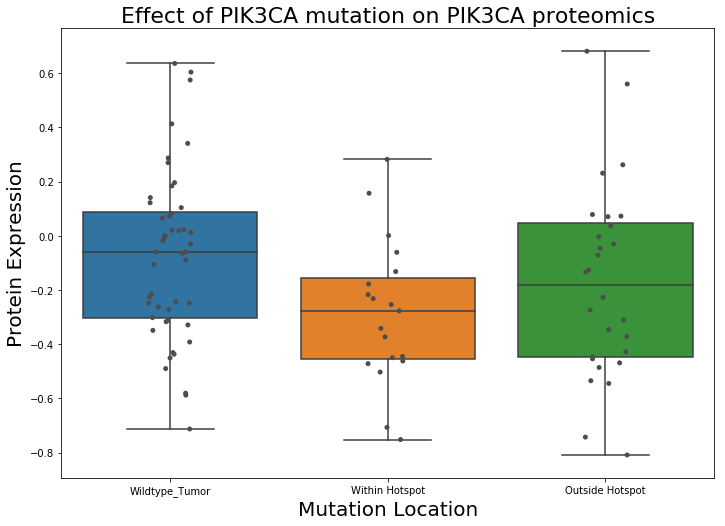

In [61]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p110_mutations_protein, x = 'Within_Hotspot', order = ['Wildtype_Tumor', 'Within Hotspot', 'Outside Hotspot'], y = protein, ax = ax)
boxplt = sns.stripplot(data = p110_mutations_protein, x = 'Within_Hotspot', y = protein, order = ['Wildtype_Tumor', 'Within Hotspot', 'Outside Hotspot'], jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Location', fontsize='20')
boxplt.set_ylabel('Protein Expression', fontsize='20')
boxplt.set_title(('{}' '{}' '{}' '{}' '{}'.format('Effect of ', gene, ' mutation on ', protein, ' proteomics')), fontsize='22')
plt.show()

### We can conclude from these results that there are no significant changes in PIK3CA protein abundance when mutated, within or outside of the hotspot. 

# 4a. Phosphoproteomic analysis

In [63]:
protein = 'PIK3CA-'
pattern = re.compile(protein)

# 1. Create a dataframe combining phosphosite data with PIK3CA mutation status; select for tumor samples
p110_mutations_phos = CPTAC.compare_mutations(phos, protein, gene)
p110_mutations_phos = p110_mutations_phos.loc[p110_mutations_phos['Sample_Status'] == 'Tumor'].drop('Sample_Status', axis = 1)

# 2. Make a new column for mutation location reative to hotspot 
p110_mutations_phos['Within_Hotspot'] = 'Outside Hotspot'
p110_mutations_phos.loc[hotspot_patients, 'Within_Hotspot'] = 'Within Hotspot'
p110_mutations_phos.loc[p110_mutations_phos['Mutation'] == 'Wildtype_Tumor', 'Within_Hotspot'] = 'Wildtype_Tumor'
p110_mutations_phos.drop('Mutation', axis = 1)

# 3. Begin constructing a dataframe for plotting, starting only with the mutation location 
plotdf = p110_mutations_phos[['Within_Hotspot']]

# 4. Loop through each phosphosite to check for significance:
for site in p110_mutations_phos.columns:
    if (site != 'Within_Hotspot' and site != 'Mutation'):
        sitedf = p110_mutations_phos[[site, 'Within_Hotspot']].dropna(axis=0)
        hotspot_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Within Hotspot']
        non_hotspot_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Outside Hotspot']
        wt_phos = sitedf.loc[sitedf['Within_Hotspot'] == 'Wildtype_Tumor']
        all_phos_mut = sitedf.loc[sitedf['Within_Hotspot'] != 'Wildtype_Tumor']
        
        #Perform a ttest for hotspot vs cancer wildtype 
        tstat, pvalue = scipy.stats.ttest_ind(hotspot_phos[site], wt_phos[site])
        print('{}' '{}' '{}' '{}'.format('PIK3CA hotspot mutation and ' , site , pvalue, '\n'))
        plotdf = plotdf.join(p110_mutations_phos[site])
        
        #Perform a ttest for all mutations vs cancer wildtype
        tstat, pvalue = scipy.stats.ttest_ind(all_phos_mut[site], wt_phos[site])
        print('{}' '{}' '{}' '{}'.format('All PIK3CA mutation and ' , site , pvalue, '\n'))
        
        #Perform a ttest for non-hotspot mutations vs cancer wildtype
        ttest = scipy.stats.ttest_ind(non_hotspot_phos[site], wt_phos[site])
        print('{}' '{}' '{}' '{}'.format('Non-hotspot PIK3CA mutation and ' , site , pvalue, '\n\n'))
        

PIK3CA hotspot mutation and PIK3CA-S3120.19790721592477073

All PIK3CA mutation and PIK3CA-S3120.11761482610077076

Non-hotspot PIK3CA mutation and PIK3CA-S3120.11761482610077076


PIK3CA hotspot mutation and PIK3CA-T3130.06448893959367591

All PIK3CA mutation and PIK3CA-T3130.09652978190603953

Non-hotspot PIK3CA mutation and PIK3CA-T3130.09652978190603953




# 4b. Plot the data

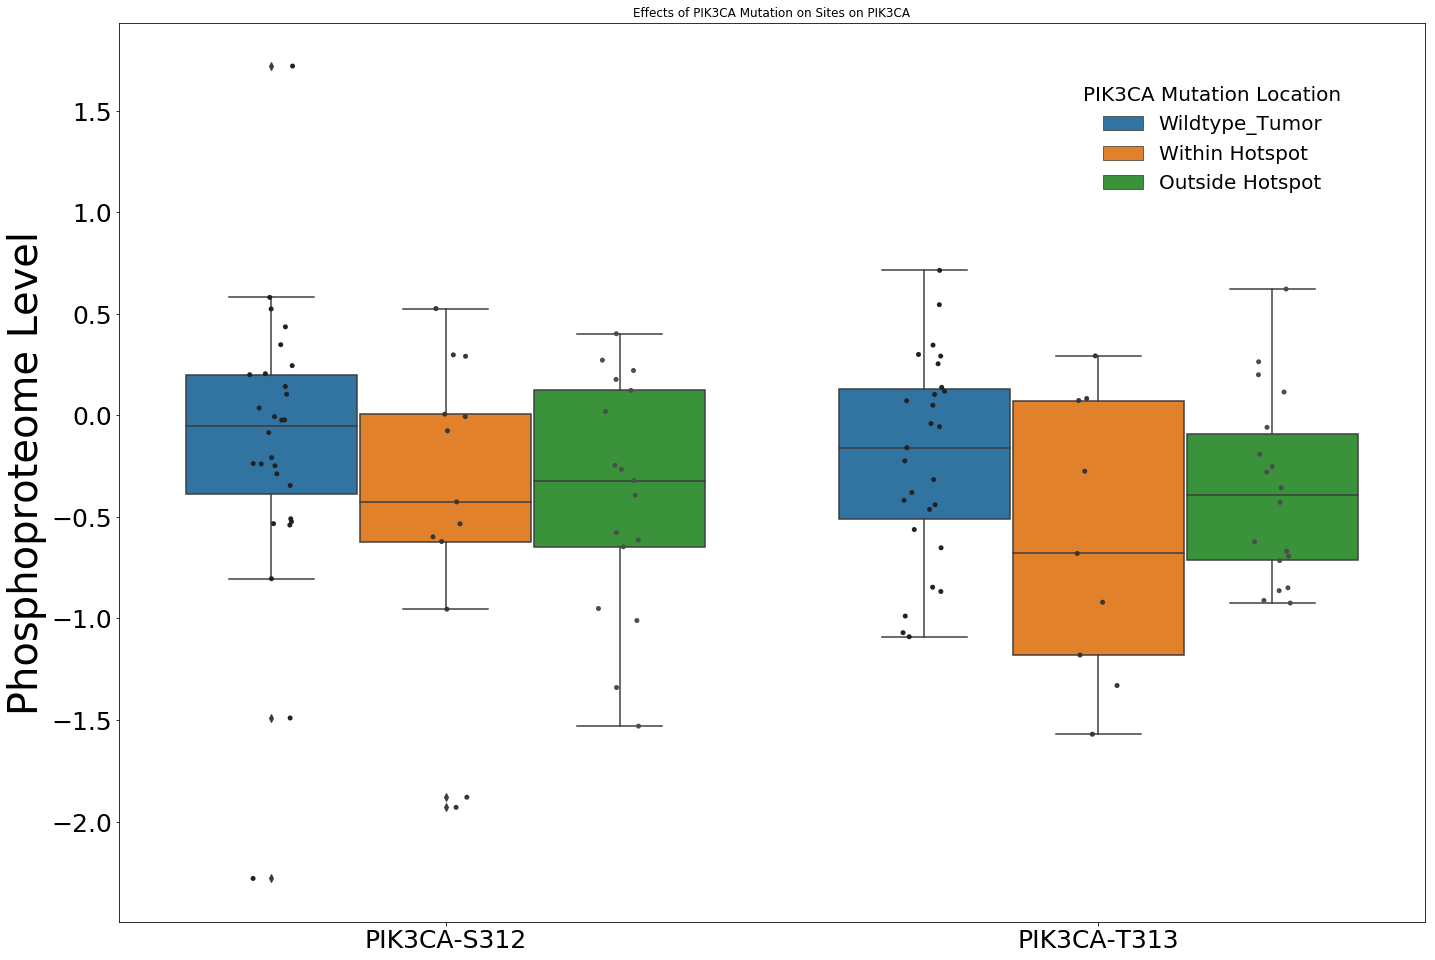

In [51]:
#Create the plot dataframe by combining the data from the two PIK3CA phosphosites 
plotdf = pd.melt(plotdf, id_vars = ['Within_Hotspot'], var_name = 'Site', value_name = 'Phos')
plotdf = plotdf.dropna(axis = 0)

#Set the plot dimsensions
a4_dims = (23.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)


#Create the plot
boxplt = sns.boxplot(x='Site', y='Phos', hue = 'Within_Hotspot', hue_order = ['Wildtype_Tumor', 'Within Hotspot', 'Outside Hotspot'], data=plotdf)
boxplt = sns.stripplot(data=plotdf, x='Site', y='Phos', hue='Within_Hotspot', hue_order = ['Wildtype_Tumor', 'Within Hotspot', 'Outside Hotspot'], dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Phosphoproteome Level', fontsize='40')
boxplt.tick_params(labelsize='25')
boxplt.set_title('Effects of PIK3CA Mutation on Sites on PIK3CA')
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:3], ['Wildtype_Tumor', 'Within Hotspot', 'Outside Hotspot'], title='PIK3CA Mutation Location', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
boxplt.get_legend().set_bbox_to_anchor((0.95, 0.95, 0, 0))

### We can conclude that PIK3CA mutation, within or outside of the hotspot, does not affect its phosphorylation levels 